In [2]:
!pip install pandas fastavro matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import fastavro
import os
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt


# **Data download and processing**

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O adult.data

column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

data_df = pd.read_csv('adult.data', names=column_names, skipinitialspace=True, na_values="?")

data_df.fillna('Unknown', inplace=True)

data_df['age_category'] = pd.cut(data_df['age'], bins=[0, 25, 50, 100], labels=['Young', 'Adult', 'Senior'])
data_df['capital_gain_levels'] = pd.cut(data_df['capital_gain'], bins=[-1, 0, 5000, 10000, 99999], labels=['None', 'Low', 'Medium', 'High'])
data_df['income'] = data_df['income'].map({'<=50K': 0, '>50K': 1})


--2024-05-10 22:39:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [     <=>            ]   3.79M  3.13MB/s    in 1.2s    

2024-05-10 22:39:36 (3.13 MB/s) - ‘adult.data’ saved [3974305]



# **Data visualization**

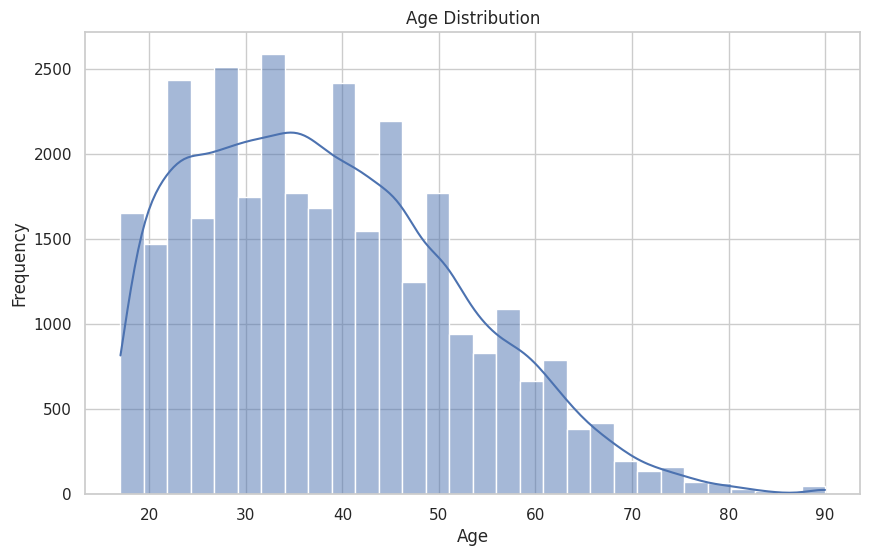

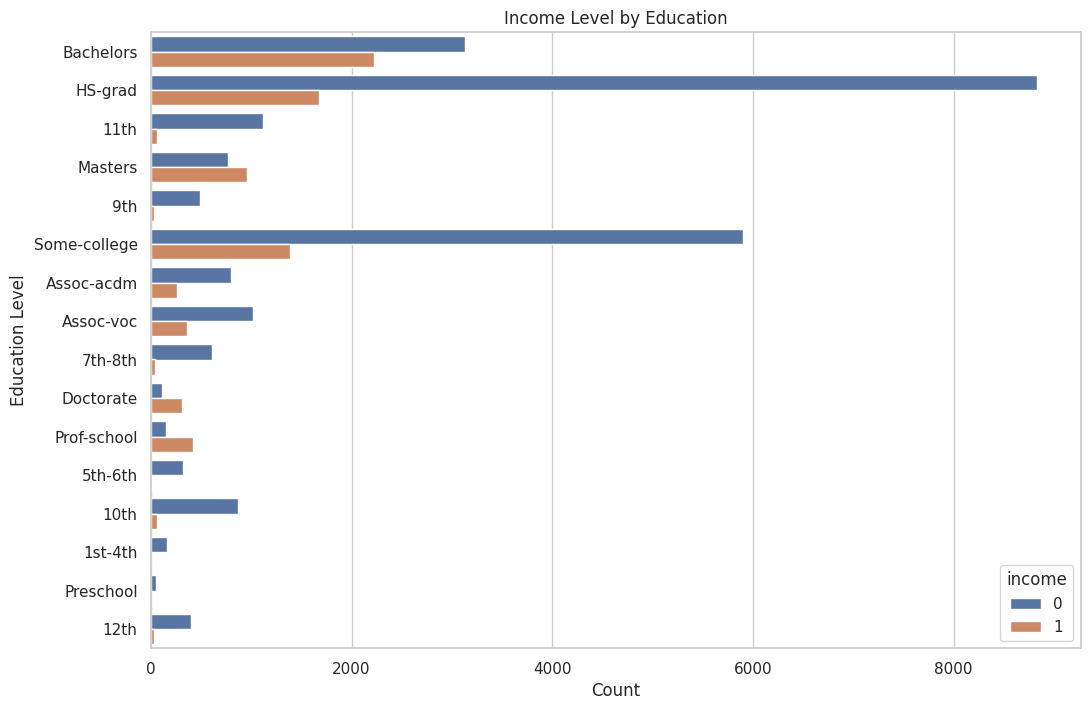

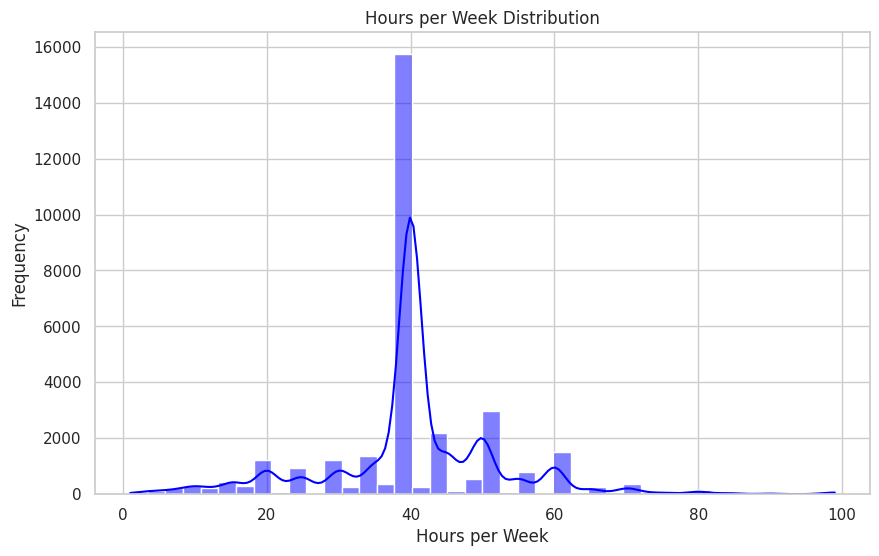

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data_df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(y='education', hue='income', data=data_df)
plt.title('Income Level by Education')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data_df['hours_per_week'], bins=40, color='blue', kde=True)
plt.title('Hours per Week Distribution')
plt.xlabel('Hours per Week')
plt.ylabel('Frequency')
plt.show()


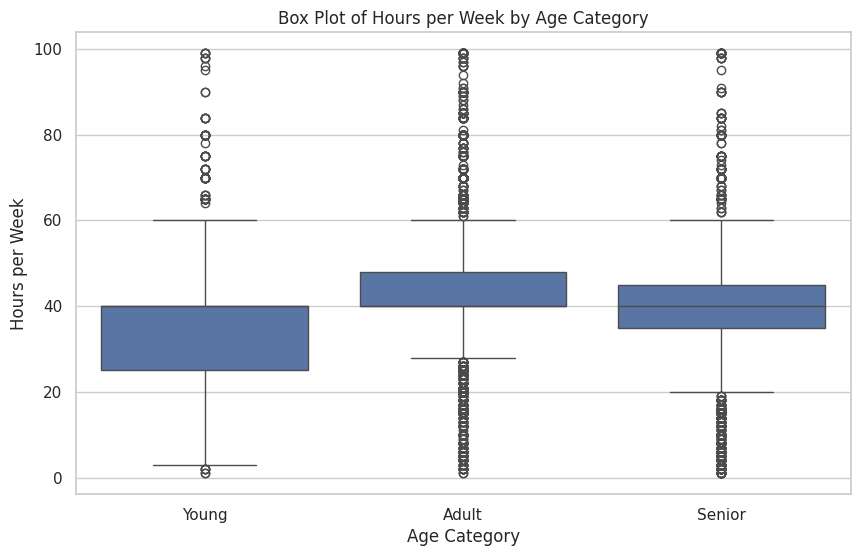

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_category', y='hours_per_week', data=data_df)
plt.title('Box Plot of Hours per Week by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Hours per Week')
plt.show()

# **Avro**

In [6]:
schema = {
  "namespace": "example.avro",
  "type": "record",
  "name": "User",
  "fields": [
    {"name": "age", "type": "int"},
    {"name": "workclass", "type": ["string", "null"]},
    {"name": "fnlwgt", "type": "int"},
    {"name": "education", "type": ["string", "null"]},
    {"name": "education_num", "type": "int"},
    {"name": "marital_status", "type": ["string", "null"]},
    {"name": "occupation", "type": ["string", "null"]},
    {"name": "relationship", "type": ["string", "null"]},
    {"name": "race", "type": ["string", "null"]},
    {"name": "sex", "type": ["string", "null"]},
    {"name": "capital_gain", "type": "int"},
    {"name": "capital_loss", "type": "int"},
    {"name": "hours_per_week", "type": "int"},
    {"name": "native_country", "type": ["string", "null"]},
    {"name": "income", "type": "int"}
  ]
}

parsed_schema = fastavro.parse_schema(schema)
records = data_df.to_dict(orient='records')

with open('serialized_output.avro', 'wb') as out_file:
    fastavro.writer(out_file, parsed_schema, records)


In [7]:
from google.colab import files
files.download('serialized_output.avro')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Performance test**

In [9]:
import psutil
def measure_performance(records):
    process = psutil.Process(os.getpid())

    # Avro
    avro_start_memory = process.memory_info().rss
    cpu_start = psutil.cpu_percent(interval=None)
    start_time = time.time()
    with open('serialized_output.avro', 'rb') as in_file:
        avro_reader = fastavro.reader(in_file)
        for record in avro_reader:
            pass
    avro_time = time.time() - start_time
    avro_end_memory = process.memory_info().rss
    avro_size = os.path.getsize('serialized_output.avro')
    avro_memory_usage = (avro_end_memory - avro_start_memory) / (1024 ** 2)
    cpu_end = psutil.cpu_percent(interval=None)
    avro_cpu_usage = cpu_end - cpu_start

    # JSON
    json_start_memory = process.memory_info().rss
    cpu_start = psutil.cpu_percent(interval=None)
    records = data_df.to_dict('records')
    start_time = time.time()
    with open('data.json', 'w') as json_file:
        json.dump(records, json_file)
    json_time = time.time() - start_time
    json_end_memory = process.memory_info().rss
    json_size = os.path.getsize('data.json')
    json_memory_usage = (json_end_memory - json_start_memory) / (1024 ** 2)
    cpu_end = psutil.cpu_percent(interval=None)
    json_cpu_usage = cpu_end - cpu_start

    print(f"Avro: Time = {avro_time}s, Size = {avro_size} bytes, Memory Usage = {avro_memory_usage} MB, CPU Usage = {avro_cpu_usage}%")
    print(f"JSON: Time = {json_time}s, Size = {json_size} bytes, Memory Usage = {json_memory_usage} MB, CPU Usage = {json_cpu_usage}%")


measure_performance(records)

Avro: Time = 0.8749754428863525s, Size = 3279102 bytes, Memory Usage = 0.0 MB, CPU Usage = 73.0%
JSON: Time = 2.8039684295654297s, Size = 12871461 bytes, Memory Usage = 21.51171875 MB, CPU Usage = 98.2%


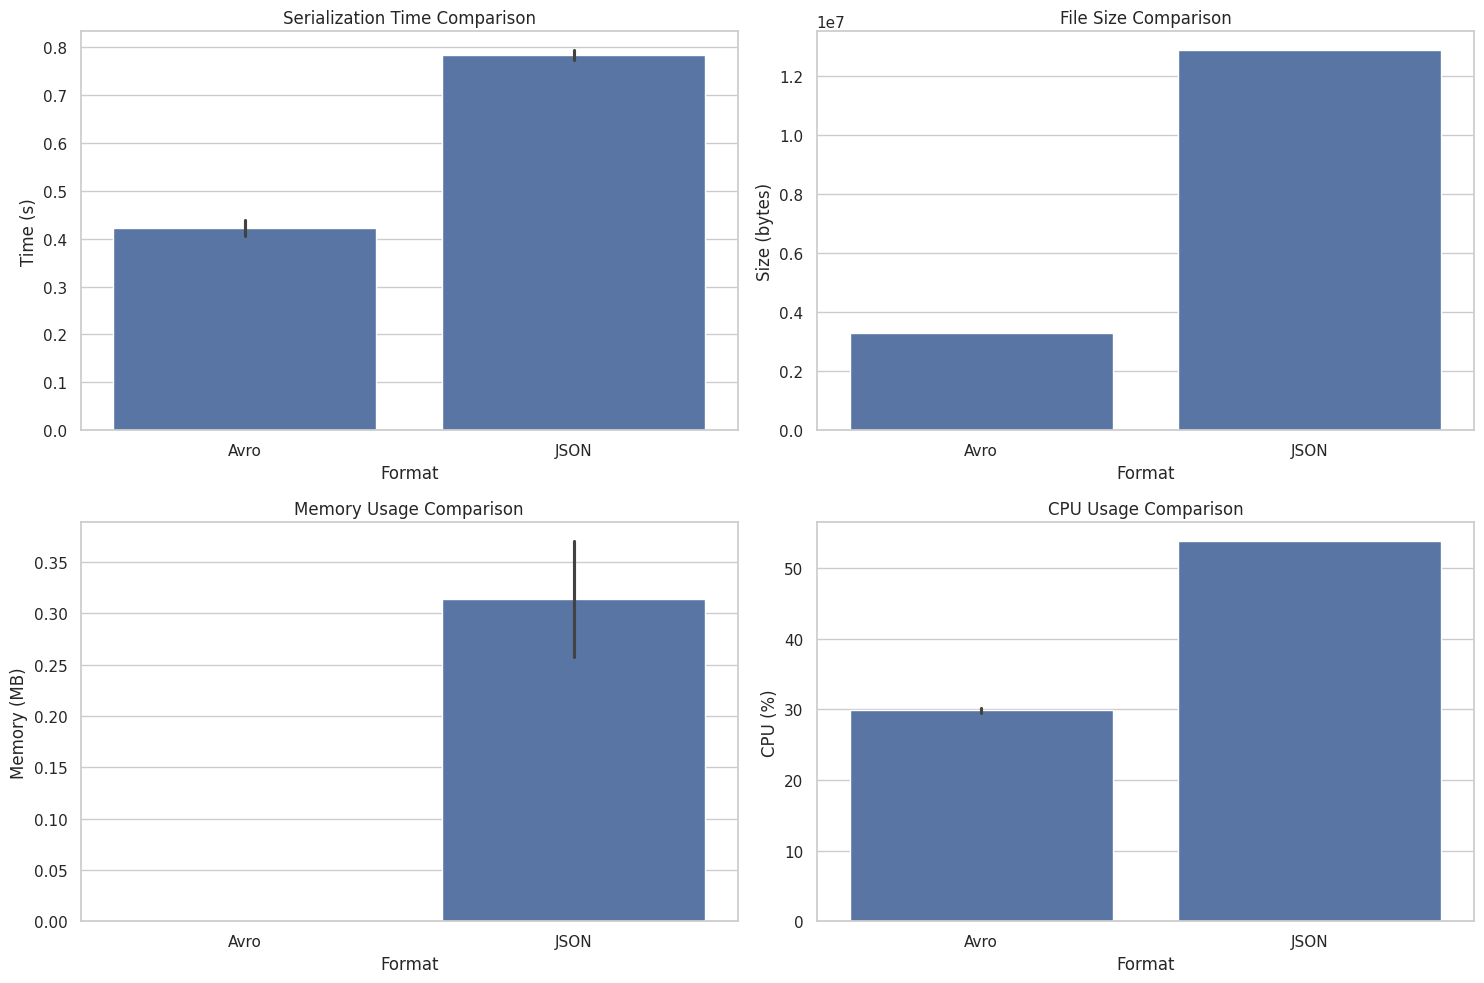

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

results = [
    {'Format': 'Avro', 'Time (s)': 0.439543485641479, 'Size (bytes)': 3279102, 'Memory (MB)': 0, 'CPU (%)': 29.5},
    {'Format': 'JSON', 'Time (s)': 0.7733843326568604, 'Size (bytes)': 12871461, 'Memory (MB)': 0.2578125, 'CPU (%)': 53.8},
    {'Format': 'Avro', 'Time (s)': 0.40562891960144043, 'Size (bytes)': 3279102, 'Memory (MB)': 0, 'CPU (%)': 30.199999999999996},
    {'Format': 'JSON', 'Time (s)': 0.7935149669647217, 'Size (bytes)': 12871461, 'Memory (MB)': 0.37, 'CPU (%)': 53.8}
]

import pandas as pd
df = pd.DataFrame(results)

sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Time
sns.barplot(x='Format', y='Time (s)', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Serialization Time Comparison')

# Size
sns.barplot(x='Format', y='Size (bytes)', data=df, ax=axs[0, 1])
axs[0, 1].set_title('File Size Comparison')

# Memory Usage
sns.barplot(x='Format', y='Memory (MB)', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Memory Usage Comparison')

# CPU
sns.barplot(x='Format', y='CPU (%)', data=df, ax=axs[1, 1])
axs[1, 1].set_title('CPU Usage Comparison')

plt.tight_layout()
plt.show()


# **Kafka**

In [11]:
import time
import random
import json

def generate_data():
    while True:
        data = {
            "user_id": random.randint(1, 100),
            "activity": random.choice(["login", "logout", "purchase"]),
            "timestamp": time.time()
        }
        yield json.dumps(data)
        time.sleep(1)


In [12]:
def process_data(data):
    print(f"Received data: {data}")

In [ ]:
def simulate_data_stream():
    data_generator = generate_data()
    for data in data_generator:
        process_data(data)

simulate_data_stream()


Received data: {"user_id": 12, "activity": "purchase", "timestamp": 1715306152.0669982}
Received data: {"user_id": 16, "activity": "login", "timestamp": 1715306153.0682442}
Received data: {"user_id": 50, "activity": "logout", "timestamp": 1715306154.0695126}
Received data: {"user_id": 23, "activity": "login", "timestamp": 1715306155.0707707}
Received data: {"user_id": 89, "activity": "login", "timestamp": 1715306156.0711775}
Received data: {"user_id": 39, "activity": "logout", "timestamp": 1715306157.0724642}
Received data: {"user_id": 38, "activity": "purchase", "timestamp": 1715306158.0737677}
Received data: {"user_id": 76, "activity": "login", "timestamp": 1715306159.075149}
Received data: {"user_id": 24, "activity": "logout", "timestamp": 1715306160.0764713}
Received data: {"user_id": 4, "activity": "purchase", "timestamp": 1715306161.0775118}
Received data: {"user_id": 22, "activity": "login", "timestamp": 1715306162.0781615}
Received data: {"user_id": 38, "activity": "logout", "t

KeyboardInterrupt: 

In [ ]:
activities = {}

def process_data_advanced(data):
    data = json.loads(data)
    activity = data["activity"]
    activities[activity] = activities.get(activity, 0) + 1
    print(f"Updated activities count: {activities}")

def simulate_advanced_data_stream():
    data_generator = generate_data()
    for data in data_generator:
        process_data_advanced(data)

simulate_advanced_data_stream()


Updated activities count: {'purchase': 1}
Updated activities count: {'purchase': 1, 'login': 1}
Updated activities count: {'purchase': 1, 'login': 2}
Updated activities count: {'purchase': 1, 'login': 3}
Updated activities count: {'purchase': 2, 'login': 3}
Updated activities count: {'purchase': 3, 'login': 3}
Updated activities count: {'purchase': 4, 'login': 3}
Updated activities count: {'purchase': 4, 'login': 4}
Updated activities count: {'purchase': 5, 'login': 4}
Updated activities count: {'purchase': 5, 'login': 5}
Updated activities count: {'purchase': 5, 'login': 5, 'logout': 1}
Updated activities count: {'purchase': 5, 'login': 5, 'logout': 2}


KeyboardInterrupt: 